# Set-up MLFlow

In [1]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.8/672.8 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.5 MB/s eta 0:00:00


In [2]:
import mlflow

## Connect storage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!mkdir mlflow_results

In [5]:
# To use MLFlow on Colab, we need to connect storage. We will use Google Drive

# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [6]:
# Set up experiment name. Keep the experiment name the same across all models for easy comparison
mlflow.set_experiment("Demand Forecast Guayas")

<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_results/437562355245870403', creation_time=1741439855156, experiment_id='437562355245870403', last_update_time=1741439855156, lifecycle_stage='active', name='Demand Forecast Guayas', tags={}>

## Start MLFlow UI

In [7]:
!pip install pyngrok --quiet

In [8]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [9]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [10]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel "https://96f1-34-73-0-52.ngrok-free.app" 


# Step 1: Load and Explore the Dataset

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns

In [44]:
import pandas as pd

# Load the dataset
file_path = "/content/final_preprocessed_data.csv"
df = pd.read_csv(file_path, parse_dates=["date"])

# Display the first few rows
df.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,...,lag_7,lag_30,rolling_std_7,lag_1,lag_2,lag_5,lag_10,lag_12,rolling_mean_7,dcoilwtico
0,16323662,2014-01-01,36,106716,3.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16324284,2014-01-01,36,1158720,28.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16352784,2014-01-02,24,106716,2.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,95.14
3,16353829,2014-01-02,24,1158720,20.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,95.14
4,16355696,2014-01-02,26,106716,8.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,95.14


In [45]:
#Sort data by stores and give the top stores by unit sold
df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15)
print(df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15))



store_nbr
28    8744.086807
34    7990.605468
36    5067.843740
35    4631.000000
30    2449.000000
32    1910.605468
24    1089.000000
27    1077.000000
26     884.000000
51     442.000000
Name: unit_sales, dtype: float64


In [46]:
df.shape

(1640, 22)

In [47]:
#Filter the data only fo store number 28
df=df[df['store_nbr']==28]
df.shape

(170, 22)

# Step 2. Build XGBoost model for demand forecasting

## 2.1. Setting up the Environment and Visualising the Data


In [48]:
# Install the xgboost library
!pip install xgboost

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

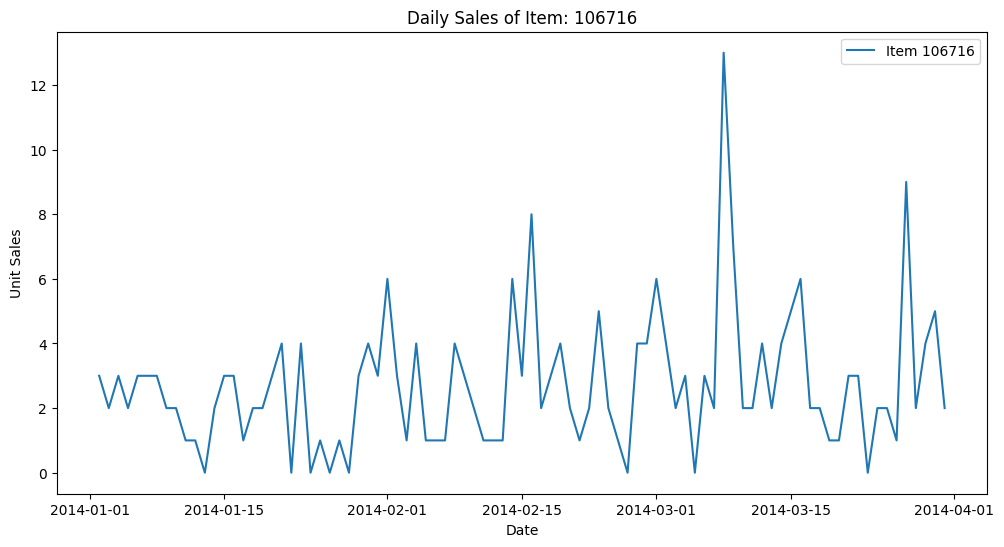

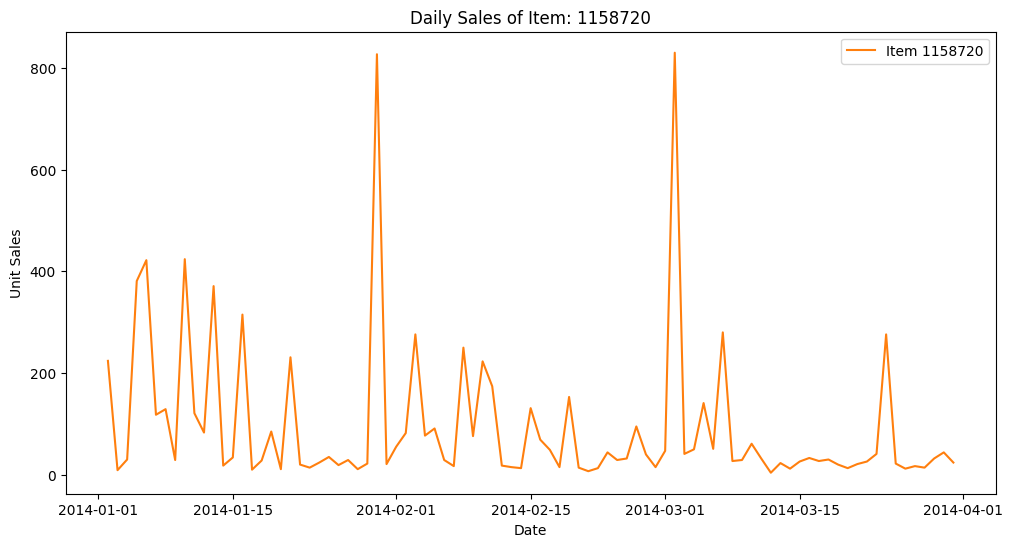

In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Create a copy of the dataframe
df_copy = df.copy()

# Generate a colormap using the recommended method
colormap = plt.colormaps.get_cmap("tab10")  # No need for extra argument

# Iterate through unique item_nbr values
for idx, item_nbr in enumerate(df_copy['item_nbr'].unique()):
    df_item = df_copy[df_copy['item_nbr'] == item_nbr].copy()

    # Group by date and sum unit_sales
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()

    # Set 'date' as the index
    df_item.set_index('date', inplace=True)

    # Fill missing dates with zero sales
    df_item = df_item.asfreq('D').fillna(0)

    # Create a plot with a different color for each item
    plt.figure(figsize=(12, 6))
    plt.plot(df_item.index, df_item['unit_sales'], color=colormap(idx % 10), label=f'Item {item_nbr}')

    plt.title(f'Daily Sales of Item: {item_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()


In [51]:
df_copy.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable', 'outlier_flag', 'holiday_flag',
       'expanding_mean', 'lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2',
       'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7', 'dcoilwtico'],
      dtype='object')

In [52]:
#Numerical features
num_features = ['store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
        'perishable', 'outlier_flag', 'holiday_flag',
       'expanding_mean', 'lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2',
       'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7', 'dcoilwtico']
#Categorical features
cat_features = ['date','family', 'class']

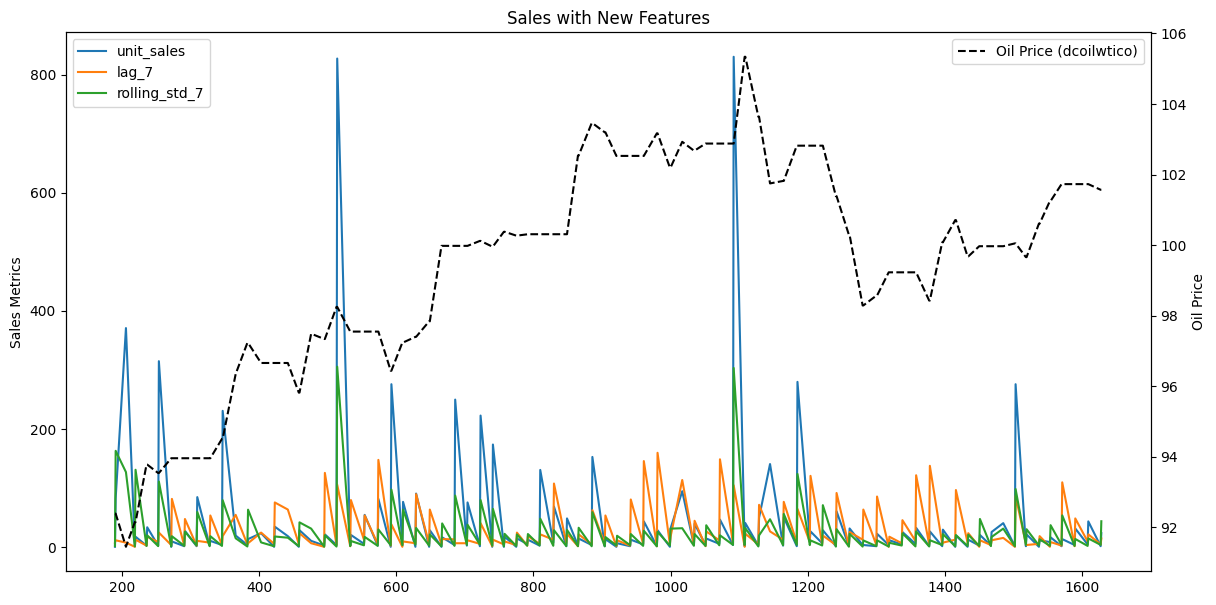

In [53]:
import matplotlib.pyplot as plt

# Drop any NaN values after creating rolling features
df_copy.dropna(inplace=True)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot sales-related features on the left y-axis
features = ['unit_sales', 'lag_7', 'rolling_std_7']
df_copy[features].plot(ax=ax1)
ax1.set_ylabel('Sales Metrics')
ax1.set_title('Sales with New Features')

# Create a second y-axis for oil prices
ax2 = ax1.twinx()
df_copy['dcoilwtico'].plot(ax=ax2, color='black', linestyle='dashed', label='Oil Price (dcoilwtico)')

# Label the right y-axis
ax2.set_ylabel('Oil Price')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


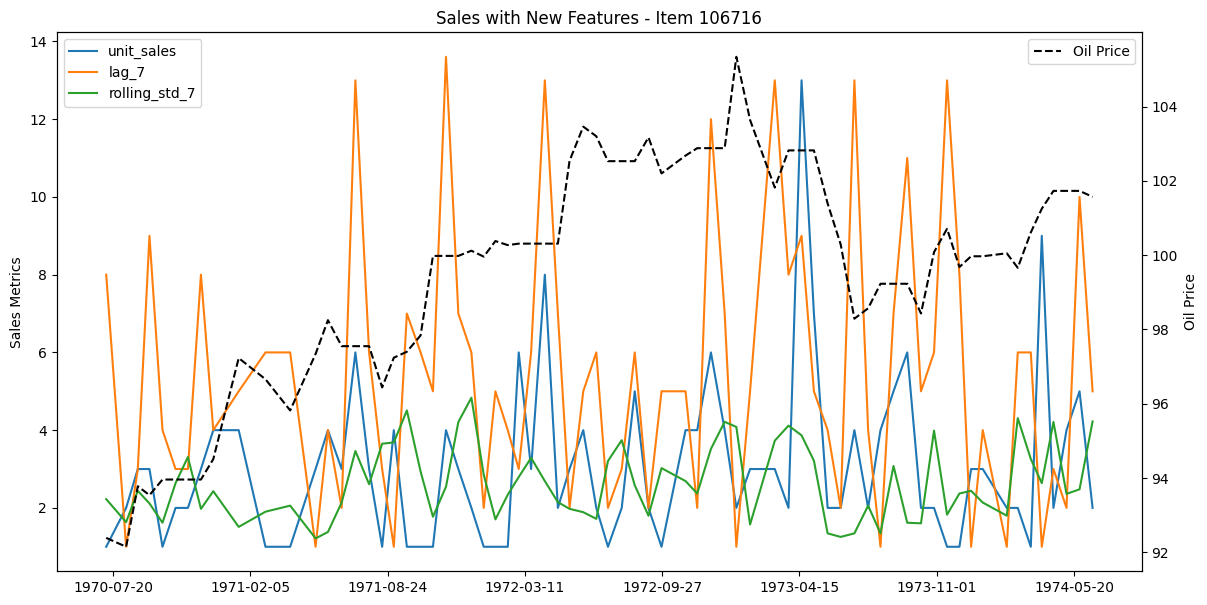

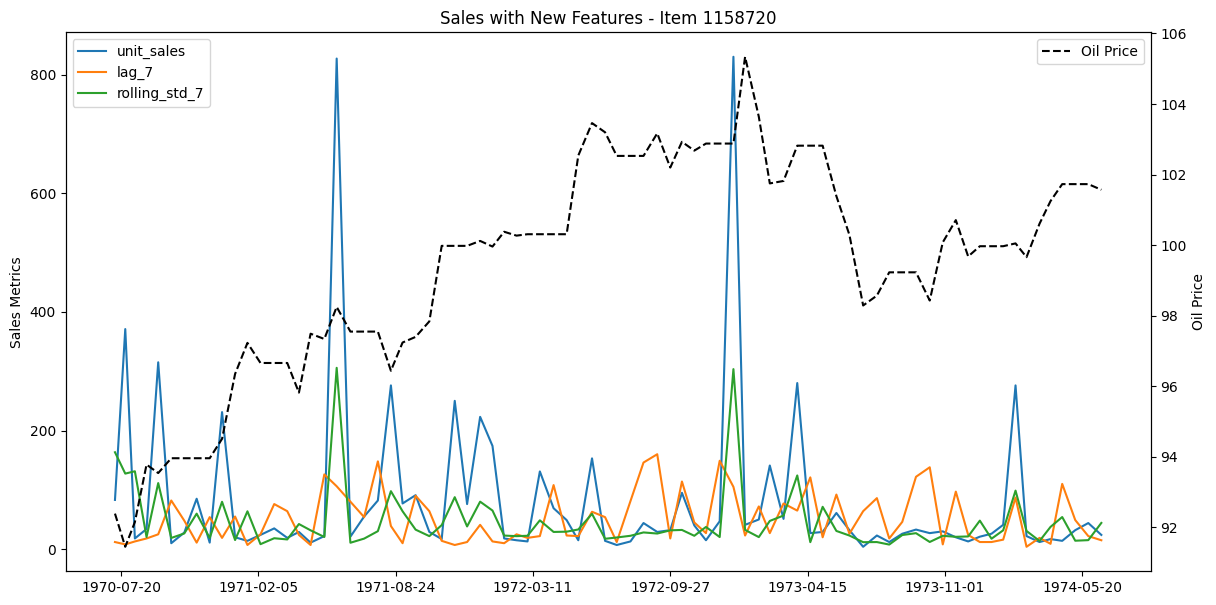

In [54]:
unique_items = df_copy['item_nbr'].unique()
for item_nbr in unique_items:
    df_item = df_copy[df_copy['item_nbr'] == item_nbr].copy()

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Ensure line plot instead of bars
    for feature in ['unit_sales', 'lag_7', 'rolling_std_7']:
        ax1.plot(df_item.index, df_item[feature], label=feature, linewidth=1.5)  # Adjust linewidth for smoothness

    ax1.set_ylabel('Sales Metrics')
    ax1.set_title(f'Sales with New Features - Item {item_nbr}')

    # Secondary y-axis for oil price
    ax2 = ax1.twinx()
    ax2.plot(df_item.index, df_item['dcoilwtico'], color='black', linestyle='dashed', linewidth=1.5, label='Oil Price')

    ax2.set_ylabel('Oil Price')

    # Format x-axis with dates
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()


## 2.2. Adding Date-based Features

In [55]:
import pandas as pd

# Ensure your index is a DatetimeIndex
df_copy = df_copy.set_index(pd.DatetimeIndex(df_copy['date']))


# Now you can extract date features
df_copy['day_of_week'] = df_copy.index.dayofweek  # 0 = Monday, 6 = Sunday
df_copy['month'] = df_copy.index.month
df_copy['is_weekend'] = df_copy['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
# Display the first few rows to verify
df_copy.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,...,lag_1,lag_2,lag_5,lag_10,lag_12,rolling_mean_7,dcoilwtico,day_of_week,month,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2014-01-12,17008479,2014-01-12,28,106716,1.0,0.0,GROCERY I,1032,0,0,...,6.0,4.0,8.0,4.0,7.0,3.571429,92.39,6,1,1
2014-01-12,17009522,2014-01-12,28,1158720,83.0,0.0,GROCERY I,1040,0,0,...,8.0,5.0,12.0,3.0,35.0,95.714286,92.39,6,1,1
2014-01-13,17075051,2014-01-13,28,1158720,371.0,0.0,GROCERY I,1040,0,0,...,13.0,65.0,8.0,27.0,10.0,89.000000,91.45,0,1,0
2014-01-14,17136849,2014-01-14,28,106716,2.0,0.0,GROCERY I,1032,0,0,...,1.0,3.0,1.0,1.0,3.0,3.000000,92.15,1,1,0
2014-01-14,17137712,2014-01-14,28,1158720,18.0,0.0,GROCERY I,1040,0,0,...,3.0,44.0,13.0,424.0,49.0,75.571429,92.15,1,1,0


## 2.3. Splitting Data into Training and Testing Sets

In [75]:

import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df_copy is already defined and has been preprocessed in previous cells
# Define target variable (unit_sales) and features
df_filtered = df_copy.copy()

X = df_filtered.drop(['unit_sales','family'], axis=1)
y = df_filtered['unit_sales']

#Create X and y for each item
unique_items = df_filtered['item_nbr'].unique()
X_items = {}
y_items = {}

# Initialize dictionaries to store the train/test splits for each item
X_train_items = {}
X_test_items = {}
y_train_items = {}
y_test_items = {}

for item_nbr in unique_items:
    X_items[item_nbr] = df_filtered[df_filtered['item_nbr'] == item_nbr].drop(['unit_sales','family'], axis=1)
    y_items[item_nbr] = df_filtered[df_filtered['item_nbr'] == item_nbr]['unit_sales']
    # Split the data into training and testing sets named with item number (80% training, 20% testing)
    #Now we store each split into a dictionary that is assigned the name of the item as its key
    X_train_items[item_nbr], X_test_items[item_nbr], y_train_items[item_nbr], y_test_items[item_nbr] = train_test_split(X_items[item_nbr], y_items[item_nbr], test_size=0.2, shuffle=False)

    print(f"Item {item_nbr}:")
    #print the shape of the item in the dictionary
    print(f"X_train shape: {X_train_items[item_nbr].shape}")
    print(f"X_test shape: {X_test_items[item_nbr].shape}")

Item 106716:
X_train shape: (56, 23)
X_test shape: (15, 23)
Item 1158720:
X_train shape: (63, 23)
X_test shape: (16, 23)


## 2.4. Implementing XGBoost for Time-Series Forecasting

Run ID: 65216d54bfcf4d268a7d3ed79055086e
Model 1 - MAE: 2.595067024230957, MSE: 9.13758939997916, RMSE: 3.022844587467103
Model 2 - MAE: 22.217890504896225, MSE: 809.5991867402919, RMSE: 28.4534564989966
✅ XGBoost models for Items 106716 and 1158720 logged successfully!


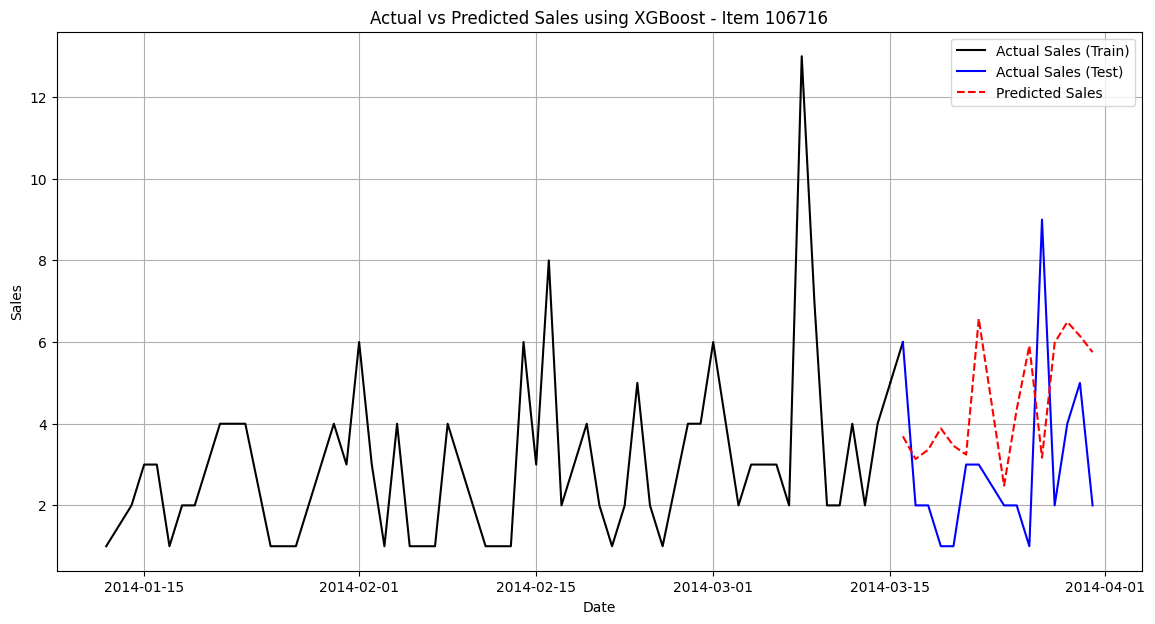

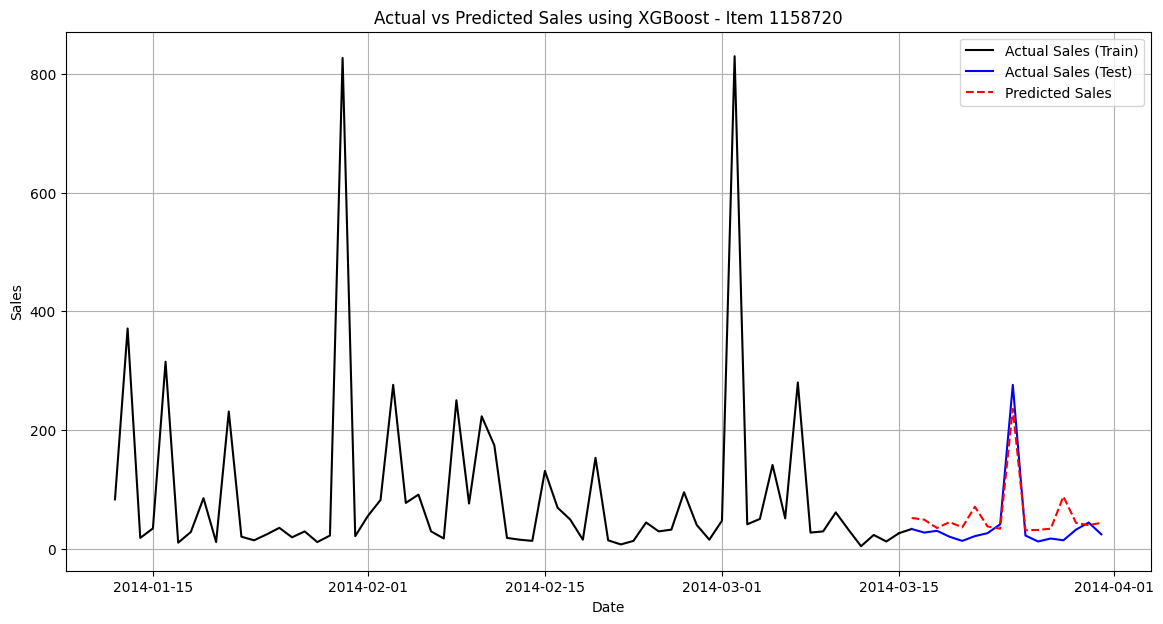

In [77]:
import os
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Start MLflow run for XGBoost models
with mlflow.start_run(run_name="XGBoost_Models") as run:
    run_id = run.info.run_id  # Get the Run ID
    print(f"Run ID: {run_id}")

    # ✅ Model 1
    xgboost_model_1 = xgb.XGBRegressor(objective='reg:squarederror',
                                       n_estimators=300, max_depth=15,
                                       learning_rate=0.01, subsample=1,
                                       colsample_bytree=0.7)

    # Convert 'date' to numerical features before training
    X_train_items[unique_items[0]] = X_train_items[unique_items[0]].copy()
    X_test_items[unique_items[0]] = X_test_items[unique_items[0]].copy()
    X_train_items[unique_items[0]]['date'] = pd.to_numeric(X_train_items[unique_items[0]]['date'])
    X_test_items[unique_items[0]]['date'] = pd.to_numeric(X_test_items[unique_items[0]]['date'])

    # Train the first XGBoost model
    xgboost_model_1.fit(X_train_items[unique_items[0]], y_train_items[unique_items[0]])

    # Make predictions on the test set
    y_pred_1 = xgboost_model_1.predict(X_test_items[unique_items[0]])

    # Evaluate Model 1
    mse_1 = mean_squared_error(y_test_items[unique_items[0]], y_pred_1)
    rmse_1 = np.sqrt(mse_1)
    mae_1 = mean_absolute_error(y_test_items[unique_items[0]], y_pred_1)

    # Log metrics for Model 1
    mlflow.log_metric(f"MAE_{unique_items[0]}", round(mae_1, 2))
    mlflow.log_metric(f"MSE_{unique_items[0]}", round(mse_1, 2))
    mlflow.log_metric(f"RMSE_{unique_items[0]}", round(rmse_1, 2))

    # ✅ Model 2
    xgboost_model_2 = xgb.XGBRegressor(objective='reg:squarederror',
                                       n_estimators=300, max_depth=15,
                                       learning_rate=0.01, subsample=1,
                                       colsample_bytree=0.7)

    # Convert 'date' to numerical features before training
    X_train_items[unique_items[1]] = X_train_items[unique_items[1]].copy()
    X_test_items[unique_items[1]] = X_test_items[unique_items[1]].copy()
    X_train_items[unique_items[1]]['date'] = pd.to_numeric(X_train_items[unique_items[1]]['date'])
    X_test_items[unique_items[1]]['date'] = pd.to_numeric(X_test_items[unique_items[1]]['date'])

    # Train the second XGBoost model
    xgboost_model_2.fit(X_train_items[unique_items[1]], y_train_items[unique_items[1]])

    # Make predictions on the test set
    y_pred_2 = xgboost_model_2.predict(X_test_items[unique_items[1]])

    # Evaluate Model 2
    mse_2 = mean_squared_error(y_test_items[unique_items[1]], y_pred_2)
    rmse_2 = np.sqrt(mse_2)
    mae_2 = mean_absolute_error(y_test_items[unique_items[1]], y_pred_2)
    print(f"Model 1 - MAE: {mae_1}, MSE: {mse_1}, RMSE: {rmse_1}")
    print(f"Model 2 - MAE: {mae_2}, MSE: {mse_2}, RMSE: {rmse_2}")

    # Log metrics for Model 2
    mlflow.log_metric(f"MAE_{unique_items[1]}", round(mae_2, 2))
    mlflow.log_metric(f"MSE_{unique_items[1]}", round(mse_2, 2))
    mlflow.log_metric(f"RMSE_{unique_items[1]}", round(rmse_2, 2))

    # ✅ Generate and Save Prediction Plots
    for i, (y_train, y_test, y_pred, item) in enumerate(
        [(y_train_items[unique_items[0]], y_test_items[unique_items[0]], y_pred_1, unique_items[0]),
         (y_train_items[unique_items[1]], y_test_items[unique_items[1]], y_pred_2, unique_items[1])]):

        plt.figure(figsize=(14, 7))
        plt.plot(y_train.index, y_train.values, label="Actual Sales (Train)", color="black")
        #connect train and test lines using coordinates
        plt.plot([y_train.index[-1], y_test.index[0]], [y_train.iloc[-1], y_test.iloc[0]],color="black")
        plt.plot(y_test.index, y_test.values, label="Actual Sales (Test)", color="blue")
        plt.plot(y_test.index, y_pred, label="Predicted Sales", color="red", linestyle="dashed")

        plt.title(f"Actual vs Predicted Sales using XGBoost - Item {item}")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        plt.grid(True)

        # Save and log the plot
        plot_path = f"xgboost_predictions_item_{item}.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

    # ✅ Save and log the models
    with TemporaryDirectory() as tmp_dir:
        # Save Model 1
        model_path_1 = os.path.join(tmp_dir, f"xgboost_model_{unique_items[0]}.json")
        xgboost_model_1.save_model(model_path_1)
        mlflow.log_artifact(model_path_1, artifact_path="models")

        # Save Model 2
        model_path_2 = os.path.join(tmp_dir, f"xgboost_model_{unique_items[1]}.json")
        xgboost_model_2.save_model(model_path_2)
        mlflow.log_artifact(model_path_2, artifact_path="models")

    print(f"✅ XGBoost models for Items {unique_items[0]} and {unique_items[1]} logged successfully!")

# No need for mlflow.end_run() since the `with` block automatically handles it


In [60]:
#mlflow.end_run()


In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

grid_search_1 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           scoring='neg_mean_squared_error',  # Optimize for MSE
                           n_jobs=-1,  # Use all cores
                           verbose=1)

grid_search_1.fit(X_train_items[unique_items[0]], y_train_items[unique_items[0]])

# Get the best parameters
best_params_1 = grid_search_1.best_params_
print(f"Best parameters for Model 1: {best_params_1}")

# Use the best model
best_model_1 = grid_search_1.best_estimator_


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Model 1: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Model 1: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

grid_search_2 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           scoring='neg_mean_squared_error',  # Optimize for MSE
                           n_jobs=-1,  # Use all cores
                           verbose=1)

grid_search_2.fit(X_train_items[unique_items[1]], y_train_items[unique_items[1]])

# Get the best parameters
best_params_2 = grid_search_2.best_params_
print(f"Best parameters for Model 2: {best_params_2}")

# Use the best model
best_model_2 = grid_search_2.best_estimator_





Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Model 2: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

Run ID: 507bbd402add45c1a62753894079dfb6
Model 1 - MAE: 3.177555863062541, MSE: 12.434953765487144, RMSE: 3.5263229808806713
Model 2 - MAE: 28.964604620039047, MSE: 1866.596785337522, RMSE: 43.204129262577695


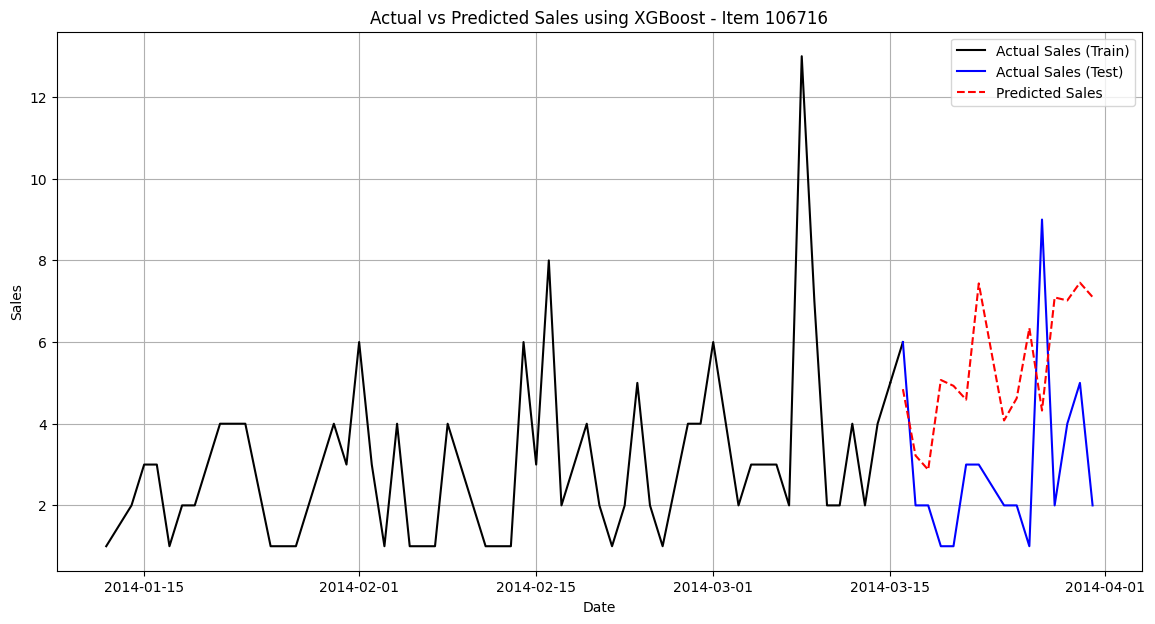

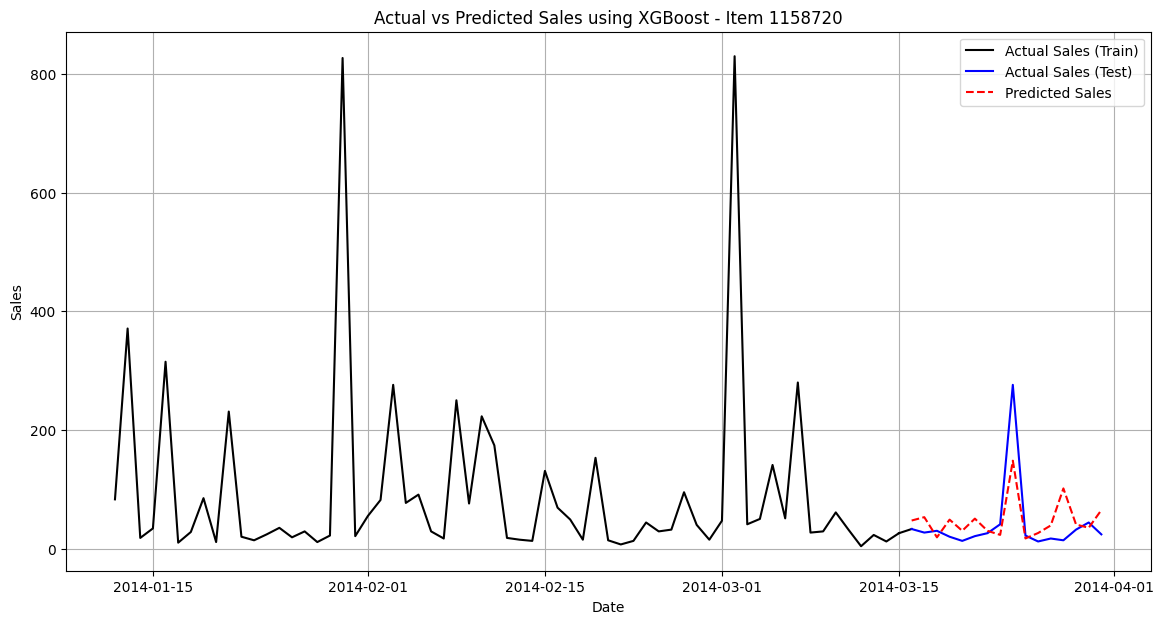

✅ XGBoost models for Items 106716 and 1158720 logged successfully!


In [78]:
import os
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Ensure variables exist and are not reset to empty dictionaries
if "X_train_items" not in locals():
    X_train_items = {}
if "X_test_items" not in locals():
    X_test_items = {}
if "y_train_items" not in locals():
    y_train_items = {}
if "y_test_items" not in locals():
    y_test_items = {}

# ✅ Ensure 'date' is converted to numeric or dropped before training
for item in unique_items:
    if item in X_train_items and "date" in X_train_items[item].columns:
        try:
            X_train_items[item] = X_train_items[item].copy()
            X_test_items[item] = X_test_items[item].copy()

            X_train_items[item]["date"] = pd.to_numeric(X_train_items[item]["date"])
            X_test_items[item]["date"] = pd.to_numeric(X_test_items[item]["date"])
        except Exception:
            print(f"⚠️ Warning: Could not convert 'date' for Item {item}. Dropping 'date' column instead.")
            X_train_items[item].drop(columns=["date"], inplace=True, errors="ignore")
            X_test_items[item].drop(columns=["date"], inplace=True, errors="ignore")

# ✅ Start a new MLflow run
with mlflow.start_run(run_name="XGBoost_Models") as run:
    run_id = run.info.run_id  # Get the Run ID
    print(f"Run ID: {run_id}")

    y_pred_1, y_pred_2 = None, None  # Ensure predictions are defined

    # ✅ Model 1
    if unique_items[0] in X_train_items and unique_items[0] in y_train_items:
        xgboost_model_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                           n_estimators=100, max_depth=6,
                                           learning_rate=0.1, colsample_bytree=0.7,
                                           subsample=0.8, alpha=0.1)

        xgboost_model_1.fit(X_train_items[unique_items[0]], y_train_items[unique_items[0]])
        y_pred_1 = xgboost_model_1.predict(X_test_items[unique_items[0]])

        # Evaluate Model 1
        mse_1 = mean_squared_error(y_test_items[unique_items[0]], y_pred_1)
        rmse_1 = np.sqrt(mse_1)
        mae_1 = mean_absolute_error(y_test_items[unique_items[0]], y_pred_1)

        # Log metrics for Model 1
        mlflow.log_metric(f"MAE_{unique_items[0]}", round(mae_1, 2))
        mlflow.log_metric(f"MSE_{unique_items[0]}", round(mse_1, 2))
        mlflow.log_metric(f"RMSE_{unique_items[0]}", round(rmse_1, 2))
    else:
        print(f"⚠️ Warning: No training data found for Item {unique_items[0]}.")

    # ✅ Model 2
    if unique_items[1] in X_train_items and unique_items[1] in y_train_items:
        xgboost_model_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                           n_estimators=200, max_depth=6,
                                           learning_rate=0.2, colsample_bytree=0.7,
                                           subsample=1.0, alpha=0.1)

        xgboost_model_2.fit(X_train_items[unique_items[1]], y_train_items[unique_items[1]])
        y_pred_2 = xgboost_model_2.predict(X_test_items[unique_items[1]])

        # Evaluate Model 2
        mse_2 = mean_squared_error(y_test_items[unique_items[1]], y_pred_2)
        rmse_2 = np.sqrt(mse_2)
        mae_2 = mean_absolute_error(y_test_items[unique_items[1]], y_pred_2)

        print(f"Model 1 - MAE: {mae_1}, MSE: {mse_1}, RMSE: {rmse_1}")
        print(f"Model 2 - MAE: {mae_2}, MSE: {mse_2}, RMSE: {rmse_2}")

        # Log metrics for Model 2
        mlflow.log_metric(f"MAE_{unique_items[1]}", round(mae_2, 2))
        mlflow.log_metric(f"MSE_{unique_items[1]}", round(mse_2, 2))
        mlflow.log_metric(f"RMSE_{unique_items[1]}", round(rmse_2, 2))
    else:
        print(f"⚠️ Warning: No training data found for Item {unique_items[1]}.")

    # ✅ Generate and Save Prediction Plots
    for item, y_train, y_test, y_pred in [
        (unique_items[0], y_train_items.get(unique_items[0]), y_test_items.get(unique_items[0]), y_pred_1),
        (unique_items[1], y_train_items.get(unique_items[1]), y_test_items.get(unique_items[1]), y_pred_2)
    ]:
        if y_train is not None and y_test is not None and y_pred is not None:
            plt.figure(figsize=(14, 7))
            plt.plot(y_train.index, y_train.values, label="Actual Sales (Train)", color="black")
            #connect train and test lines using coordinates
            plt.plot([y_train.index[-1], y_test.index[0]], [y_train.iloc[-1], y_test.iloc[0]],color="black")
            plt.plot(y_test.index, y_test.values, label="Actual Sales (Test)", color="blue")
            plt.plot(y_test.index, y_pred, label="Predicted Sales", color="red", linestyle="dashed")

            plt.title(f"Actual vs Predicted Sales using XGBoost - Item {item}")
            plt.xlabel("Date")
            plt.ylabel("Sales")
            plt.legend()
            plt.grid(True)

            # ✅ Display the plot in the notebook
            plt.show()

            # ✅ Save and log the plot
            plot_path = f"xgboost_predictions_item_{item}.png"
            plt.savefig(plot_path)
            plt.close()
            mlflow.log_artifact(plot_path, artifact_path="plots")

    # ✅ Save and log the models
    with TemporaryDirectory() as tmp_dir:
        if y_pred_1 is not None:
            model_path_1 = os.path.join(tmp_dir, f"xgboost_model_{unique_items[0]}.json")
            xgboost_model_1.save_model(model_path_1)
            mlflow.log_artifact(model_path_1, artifact_path="models")

        if y_pred_2 is not None:
            model_path_2 = os.path.join(tmp_dir, f"xgboost_model_{unique_items[1]}.json")
            xgboost_model_2.save_model(model_path_2)
            mlflow.log_artifact(model_path_2, artifact_path="models")

    print(f"✅ XGBoost models for Items {unique_items[0]} and {unique_items[1]} logged successfully!")

# No need for mlflow.end_run() since the `with` block automatically handles it


In [79]:
# ✅ Feature Importance Plots (Fix: Correct Loop)
for item, model in models.items():  # ✅ Ensure we loop over models, not item numbers
    if model is not None:
        fig, ax = plt.subplots(figsize=(12, 6))
        xgb.plot_importance(model, max_num_features=10, ax=ax)
        ax.set_title(f"Feature Importance for Item {item}")

        # ✅ Save & Log Feature Importance
        importance_path = f"feature_importance_item_{item}.png"
        fig.savefig(importance_path, bbox_inches='tight')
        plt.close(fig)  # ✅ Close figure after saving

        mlflow.log_artifact(importance_path, artifact_path="plots")


Run ID: 2d804a9e948f4587abf90af9cd14a101
Model 1 - MAE: 1.4966662883758546, MSE: 4.175652430036268, RMSE: 2.043441320428915
Model 2 - MAE: 20.147451285421432, MSE: 770.0307979924611, RMSE: 27.749428786777955


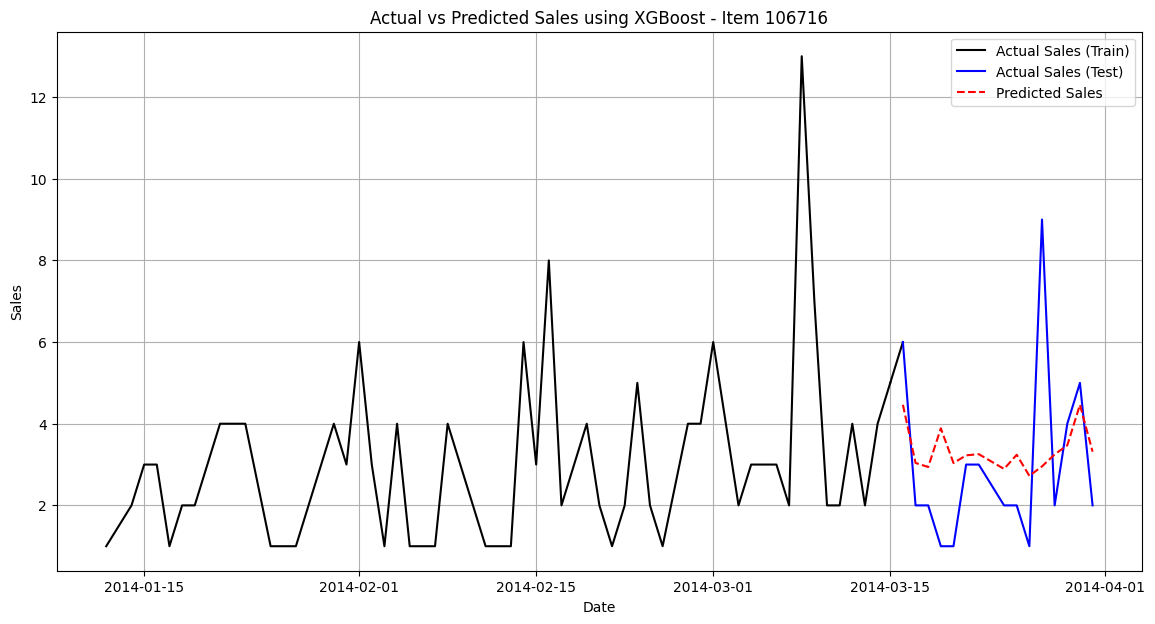

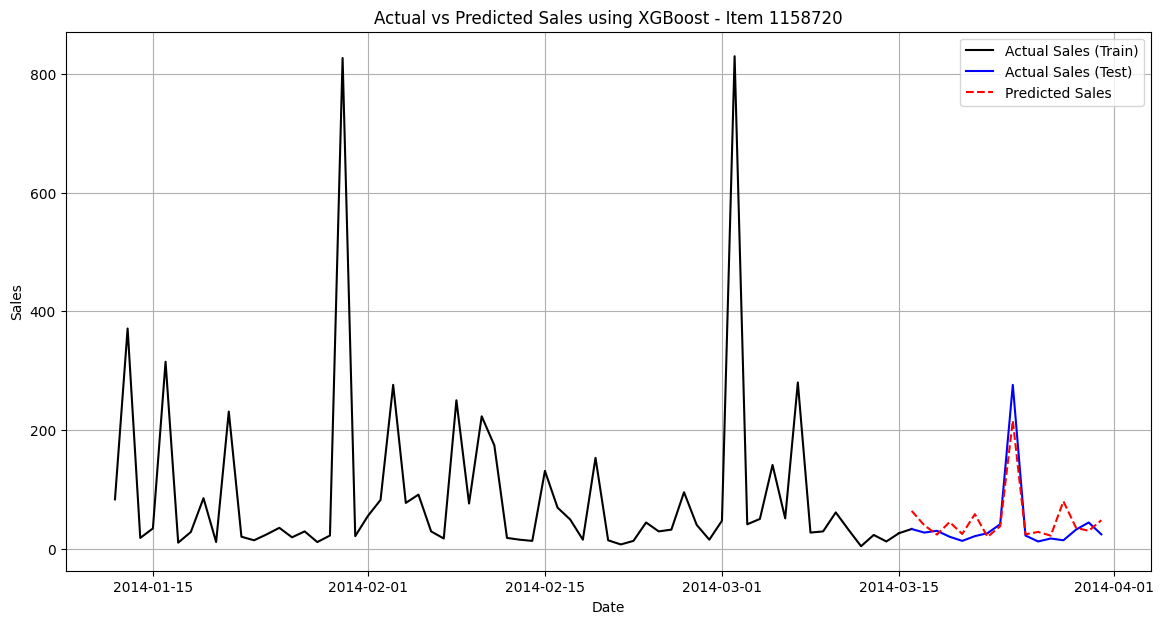

✅ XGBoost models for Items 106716 and 1158720 logged successfully!


In [82]:
import os
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Ensure feature scaling (StandardScaler)
scaler = StandardScaler()
for item in unique_items:
    if item in X_train_items:
        X_train_items[item] = scaler.fit_transform(X_train_items[item])
        X_test_items[item] = scaler.transform(X_test_items[item])

# ✅ Start MLflow run
with mlflow.start_run(run_name="XGBoost_Optimized_v2") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    y_pred_1, y_pred_2 = None, None
    models = {}  # Store models for saving

    # ✅ Model 1
    if unique_items[0] in X_train_items and unique_items[0] in y_train_items:
        xgboost_model_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                           n_estimators=250,
                                           max_depth=6,
                                           learning_rate=0.07,
                                           colsample_bytree=0.8,
                                           subsample=0.85,
                                           min_child_weight=5,
                                           reg_lambda=1.0,
                                           alpha=0.1,
                                           early_stopping_rounds=20)

        xgboost_model_1.fit(X_train_items[unique_items[0]], y_train_items[unique_items[0]],
                            eval_set=[(X_test_items[unique_items[0]], y_test_items[unique_items[0]])],
                            verbose=False)

        y_pred_1 = xgboost_model_1.predict(X_test_items[unique_items[0]])

        # ✅ Evaluate Model 1
        mse_1 = mean_squared_error(y_test_items[unique_items[0]], y_pred_1)
        rmse_1 = np.sqrt(mse_1)
        mae_1 = mean_absolute_error(y_test_items[unique_items[0]], y_pred_1)

        # ✅ Log metrics
        mlflow.log_metric(f"MAE_{unique_items[0]}", round(mae_1, 2))
        mlflow.log_metric(f"MSE_{unique_items[0]}", round(mse_1, 2))
        mlflow.log_metric(f"RMSE_{unique_items[0]}", round(rmse_1, 2))

        # ✅ Store model
        models[unique_items[0]] = xgboost_model_1

    # ✅ Model 2
    if unique_items[1] in X_train_items and unique_items[1] in y_train_items:
        xgboost_model_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                           n_estimators=350,
                                           max_depth=7,
                                           learning_rate=0.08,
                                           colsample_bytree=0.8,
                                           subsample=0.95,
                                           min_child_weight=3,
                                           reg_lambda=2.0,
                                           alpha=0.1,
                                           gamma=0.2,
                                           early_stopping_rounds=20)

        xgboost_model_2.fit(X_train_items[unique_items[1]], y_train_items[unique_items[1]],
                            eval_set=[(X_test_items[unique_items[1]], y_test_items[unique_items[1]])],
                            verbose=False)

        y_pred_2 = xgboost_model_2.predict(X_test_items[unique_items[1]])

        # ✅ Evaluate Model 2
        mse_2 = mean_squared_error(y_test_items[unique_items[1]], y_pred_2)
        rmse_2 = np.sqrt(mse_2)
        mae_2 = mean_absolute_error(y_test_items[unique_items[1]], y_pred_2)

        print(f"Model 1 - MAE: {mae_1}, MSE: {mse_1}, RMSE: {rmse_1}")
        print(f"Model 2 - MAE: {mae_2}, MSE: {mse_2}, RMSE: {rmse_2}")

        # ✅ Log metrics
        mlflow.log_metric(f"MAE_{unique_items[1]}", round(mae_2, 2))
        mlflow.log_metric(f"MSE_{unique_items[1]}", round(mse_2, 2))
        mlflow.log_metric(f"RMSE_{unique_items[1]}", round(rmse_2, 2))

        # ✅ Store model
        models[unique_items[1]] = xgboost_model_2

    # ✅ Generate & Save Prediction Plots
    for item, y_train, y_test, y_pred in [
        (unique_items[0], y_train_items.get(unique_items[0]), y_test_items.get(unique_items[0]), y_pred_1),
        (unique_items[1], y_train_items.get(unique_items[1]), y_test_items.get(unique_items[1]), y_pred_2)
    ]:
        if y_train is not None and y_test is not None and y_pred is not None:
            fig, ax = plt.subplots(figsize=(14, 7))

            # ✅ Plot Training Data (Black)
            ax.plot(y_train.index, y_train.values, label="Actual Sales (Train)", color="black")
            #connect train and test lines
            ax.plot([y_train.index[-1], y_test.index[0]], [y_train.iloc[-1], y_test.iloc[0]],color="black")

            # ✅ Plot Test Data (Blue)
            ax.plot(y_test.index, y_test.values, label="Actual Sales (Test)", color="blue")

            # ✅ Plot Predictions (Red Dashed)
            ax.plot(y_test.index, y_pred, label="Predicted Sales", color="red", linestyle="dashed")

            ax.set_title(f"Actual vs Predicted Sales using XGBoost - Item {item}")
            ax.set_xlabel("Date")
            ax.set_ylabel("Sales")
            ax.legend()
            ax.grid(True)
            plt.show()

            # ✅ Save & Log the Plot
            plot_path = f"xgboost_predictions_item_{item}.png"
            fig.savefig(plot_path, bbox_inches='tight')  # ✅ Ensures everything is saved
            plt.close(fig)  # ✅ Explicitly close the figure

            mlflow.log_artifact(plot_path, artifact_path="plots")

    # ✅ Save & Log Models
    with TemporaryDirectory() as tmp_dir:
        for item, model in models.items():
            model_path = os.path.join(tmp_dir, f"xgboost_model_{item}.json")
            model.save_model(model_path)
            mlflow.log_artifact(model_path, artifact_path="models")

    print(f"✅ XGBoost models for Items {unique_items[0]} and {unique_items[1]} logged successfully!")

# No need for mlflow.end_run() since the `with` block automatically handles it


In [81]:
#mlflow.end_run()

In [83]:
import joblib

# Define paths to save models
model_1_path = "xgboost_model_stor_1.pkl"
model_2_path = "BEST_xgboost_model_stor_2.pkl"

# Save models using joblib
joblib.dump(xgboost_model_1, model_1_path)
joblib.dump(xgboost_model_2, model_2_path)

print(f"Model 1 saved to: {model_1_path}")
print(f"Model 2 saved to: {model_2_path}")

# To load the models back
loaded_xgb_model_1 = joblib.load(model_1_path)
loaded_xgb_model_2 = joblib.load(model_2_path)

print("Models successfully loaded!")


Model 1 saved to: xgboost_model_stor_1.pkl
Model 2 saved to: BEST_xgboost_model_stor_2.pkl
Models successfully loaded!


# Conclusions

✔ This method is valid for time series forecasting with XGBoost.
✔ It uses lags, scaling, and confidence intervals, which are essential for robust predictions.
✔ It is commonly used in real-world sales forecasting when complex seasonality effects are not dominant.

⚠ However, there are some limitations:

XGBoost does not inherently model time-based dependencies, meaning methods like ARIMA, LSTM, or Prophet could provide better results for certain datasets.
There is no explicit seasonality modeling, which may reduce accuracy if seasonality is significant.
Manual scaling may not always be correct, though it can work well for stable data.

If the data has strong seasonality or trend shifts, specialized time series models (e.g., ARIMA, Prophet, LSTM) are recommended.

# NEXT Model LSTM here: MLFlow_One_Store_two_items_Guayas_PROPHET_model_Guayas_items https://colab.research.google.com/drive/10xVTFCfvpaBVRQu_jY8pneKG9RDmtnFU?usp=sharing

Predictions without corrections: